In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from botorch.acquisition.active_learning import qNegIntegratedPosteriorVariance
from botorch.models.gp_regression import SingleTaskGP
from tqdm import tqdm
from torch import Tensor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer,StandardScaler
import os

from botorch.exceptions.warnings import BotorchTensorDimensionWarning, InputDataWarning 

warnings.filterwarnings(
            "ignore",
            message="Input data is not standardized.",
            category=InputDataWarning,
        )

In [3]:
os.getcwd()

'/Users/ramseyissa/Documents/GitHub/qNIPV/notebooks'

In [5]:
df = pd.read_csv('../datasets/citrine_thermal_conductivity.csv')
df

,formula,k_expt,k-units,k_condition,k_condition_units
0,BeS,157.0,W/m.K,room temperature,"[{'name': 'Temperature', 'scalars': [{'value':..."
1,CdS,19.9,W/m.K,room temperature,"[{'name': 'Temperature', 'scalars': [{'value':..."
2,GaN,181.0,W/m.K,room temperature,"[{'name': 'Temperature', 'scalars': [{'value':..."
3,ZnO,64.5,W/m.K,room temperature,"[{'name': 'Temperature', 'scalars': [{'value':..."
4,ZnSe,15.6,W/m.K,room temperature,"[{'name': 'Temperature', 'scalars': [{'value':..."
...,...,...,...,...,...
867,SiC,40.0,Wm$^{-1}$K$^{-1}$,1773,K
868,Al2O3,6.0,Wm$^{-1}$K$^{-1}$,1773,K
869,ZrO2,2.4,Wm$^{-1}$K$^{-1}$,1773,K
870,ThO2,2.0,Wm$^{-1}$K$^{-1}$,1773,K


In [6]:
df.head()
df.value_counts()

formula            k_expt    k-units            k_condition       k_condition_units                                                    
Sr0.61Ba0.39Nb2O6  1.6670    W/m$\cdot$K        300               K                                                                        3
TiO2               0.3800    W\m K              Room temperature  [{'name': 'Temperature', 'scalars': [{'value': 'Room temperature'}]}]    3
CuBr               2.7500    W/m.K              room temperature  [{'name': 'Temperature', 'scalars': [{'value': 'room temperature'}]}]    2
GaN                181.0000  W/m.K              room temperature  [{'name': 'Temperature', 'scalars': [{'value': 'room temperature'}]}]    2
BeO                447.0000  W/m.K              room temperature  [{'name': 'Temperature', 'scalars': [{'value': 'room temperature'}]}]    2
                                                                                                                                          ..
CuCr0.97Mg0.03O2  

In [8]:
df['k_condition'].value_counts()

k_condition
300                 204
400                 187
700                 183
1000                129
room temperature     42
773                  25
373                  24
Room temperature     22
298                  19
1273                 19
1773                 10
Standard              8
Name: count, dtype: int64

In [7]:
for val in df['k_condition'].values:
    if val == 'room temperature':
        df['k_condition'] = df['k_condition'].replace(val, 300)
    elif val == 'Standard':
        df['k_condition'] = df['k_condition'].replace(val, 300)
    elif val == 'Room temperature':
        df['k_condition'] = df['k_condition'].replace(val, 300)
    else:
        pass

    

In [11]:
df['k_condition'].value_counts()

k_condition
300     204
400     187
700     183
1000    129
300      72
773      25
373      24
298      19
1273     19
1773     10
Name: count, dtype: int64

In [15]:
df['k_condition'].value_counts()

k_condition
300     204
400     187
700     183
1000    129
300      72
773      25
373      24
298      19
1273     19
1773     10
Name: count, dtype: int64

In [17]:
df.columns

Index(['formula', 'k_expt', 'k-units', 'k_condition', 'k_condition_units'], dtype='object')

In [8]:
df.head()
df.drop(columns=['k-units','k_condition_units'],inplace=True)
df.head()

,formula,k_expt,k_condition
0,BeS,157.0,300
1,CdS,19.9,300
2,GaN,181.0,300
3,ZnO,64.5,300
4,ZnSe,15.6,300


In [9]:
x = 0
for indx,row in df.iterrows():
    if row['k_condition'] == 300 or row['k_condition'] == 298:
        x += 1
print(x)
        
# convert the k_condition column to float
df['k_condition'] = df['k_condition'].astype(float)



72


In [10]:
df['k_condition'].value_counts()

#create mask for certain values in the k_condition column
mask = (df['k_condition'] == 300.0) | (df['k_condition'] == 298.0)
df_mask = df[mask]
df_mask


,formula,k_expt,k_condition
0,BeS,157.0,300.0
1,CdS,19.9,300.0
2,GaN,181.0,300.0
3,ZnO,64.5,300.0
4,ZnSe,15.6,300.0
...,...,...,...
796,SiO2,11.0,298.0
797,Al2O3,38.0,298.0
798,ZrO2,1.8,298.0
799,ThO2,14.0,298.0


In [11]:
df_mask.reset_index(drop=True,inplace=True)
df_mask

,formula,k_expt,k_condition
0,BeS,157.0,300.0
1,CdS,19.9,300.0
2,GaN,181.0,300.0
3,ZnO,64.5,300.0
4,ZnSe,15.6,300.0
...,...,...,...
290,SiO2,11.0,298.0
291,Al2O3,38.0,298.0
292,ZrO2,1.8,298.0
293,ThO2,14.0,298.0


In [12]:
df_mask.drop(columns=['k_condition'],inplace=True)
df_mask

/var/folders/qf/pmcgmztj4v91fy0j9fq_m9kc0000gn/T/ipykernel_49322/2404063873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mask.drop(columns=['k_condition'],inplace=True)


,formula,k_expt
0,BeS,157.0
1,CdS,19.9
2,GaN,181.0
3,ZnO,64.5
4,ZnSe,15.6
...,...,...
290,SiO2,11.0
291,Al2O3,38.0
292,ZrO2,1.8
293,ThO2,14.0


In [41]:
type(df_mask['formula'].value_counts())

pandas.core.series.Series

In [13]:
df_mask['formula'].value_counts()

formula
TiO2                          22
Ba8Ga16Ge30                    4
Zn4Sb3                         4
SiC                            3
SiO2                           3
                              ..
Mo6Te6S2                       1
Ca0.7Y0.3MnO3                  1
Ca0.98Bi0.02Mn0.98Nb0.02O3     1
Ti0.98Nb0.02NiSn               1
MgO                            1
Name: count, Length: 233, dtype: int64

In [16]:
for vals in df_mask['formula'].value_counts().index:
    print(vals)

TiO2
Ba8Ga16Ge30
Zn4Sb3
SiC
SiO2
Bi2Te3
AlN
Sb2Te3
Sr0.61Ba0.39Nb2O6
CaMnO3
BeO
ZnO
NaCo2O4
Tl2SnTe5
CeFe3CoSb12
TiNiSn
Zr0.5Hf0.5NiSn
Yb14MnSb11
Mg2Si
CeFe4Sb12
CdS
Ca3Co4O9
AgI
CuI
GaN
CuBr
SrTi0.8Nb0.2O3
In0.2Co4Sb12
CuCl
Ba0.6Sr0.4PbO3
Mg2Si0.98Ag0.02
Sr3Ti1.6Nb0.4O7
Na0.02Pb0.98Te
SrNd0.24Ti0.76O3
LaCoO3
Nd2Cu0.98Zn0.02O4
Zr0.35Hf0.35Ti0.3NiSn
La2.74Te4
Zr0.4Hf0.4Ti0.2NiSn
Mg2Si0.98Bi0.02
Pb1.8S1.8Ti2S4
Sr1.6La0.4Nb2O7
Mg2Si0.6Ge0.4Bi0.02
Mg2Si0.995Bi0.005
Ca0.9Y0.1MnO3
Cr1.3Mo6S8
CaMn0.98Nb0.02O3
Ba8Au5.59Si39.01
Pb0.97Sr0.02TeNa0.01
Ca2.4Na0.3Bi0.3Co4O9
Ca3AlSb3
SrNd0.17Ti0.83O3
CuCr0.99Mg0.01O2
Bi2Sr2Co2O8
Ba0.3Sr0.6La0.1TiO3
Mg2Si0.999Bi0.001
La0.95Sr0.05CoO3
Zr0.5Hf0.5NiSn1.998Sb0.002
Ag0.15Sb0.15Te1.15Ge0.85
Ba0.8Sr0.2PbO3
Ba7SrAl16Si30
NbCo1.10Sn
Sr0.147Ga0.298Ge0.555
Ca4.75Na0.25Al2Sb6
CaGd0.94Mn0.06O3
BaPbO3
Zr0.25Hf0.25Ti0.5NiSn
CuCr0.97Mg0.03O2
Ti0.95Nb0.05NiSn
Ca4.95Na0.05Al2Sb6
Mg2Si0.6Ge0.4Ag0.02
Zn0.98Al0.02O
Ca0.7Ho0.3MnO3
Zr0.5Hf0.5NiSn1.994Sb0.006
BeS
Ba8Ga18Ge28

In [22]:
df_mask.columns


Index(['formula', 'k_expt'], dtype='object')

In [28]:
for vals in df_mask['formula'].value_counts().index:
    if df_mask['formula'].value_counts()[vals] > 1:
        mask_df = df_mask.loc[df_mask['formula'] == vals]
        mean_val = mask_df['k_expt'].mean()
        
        print(vals,mean_val)
        #replace the k_expt values with the mean value
        df_mask.loc[df_mask['formula'] == vals, 'k_expt'] = mean_val
        #drop the duplicate rows
        
        
    

TiO2 0.7622727272727272
Ba8Ga16Ge30 1.79
Zn4Sb3 0.8307499999999999
SiC 284.6666666666667
SiO2 6.366666666666667
Bi2Te3 2.4949707406666666
AlN 168.66666666666666
Sb2Te3 3.1110078933333334
Sr0.61Ba0.39Nb2O6 1.667
CaMnO3 7.5938799999999995
BeO 398.0
ZnO 59.23333333333333
NaCo2O4 10.491999999999999
Tl2SnTe5 5.92
CeFe3CoSb12 1.6400000000000001
TiNiSn 6.89805
Zr0.5Hf0.5NiSn 4.0179779035
Yb14MnSb11 0.97
Mg2Si 5.875
CeFe4Sb12 8.275
CdS 19.9
Ca3Co4O9 2.755
AgI 2.44
CuI 7.1
GaN 181.0
CuBr 2.75
SrTi0.8Nb0.2O3 9.19
In0.2Co4Sb12 2.5231199999999996
CuCl 1.26


In [34]:
df_mask.drop_duplicates(subset=['formula'],inplace=True)
df_mask

/var/folders/qf/pmcgmztj4v91fy0j9fq_m9kc0000gn/T/ipykernel_49322/1849380379.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mask.drop_duplicates(subset=['formula'],inplace=True)


,formula,k_expt
0,BeS,157.000000
1,CdS,19.900000
2,GaN,181.000000
3,ZnO,59.233333
4,ZnSe,15.600000
...,...,...
287,Si,150.000000
291,Al2O3,38.000000
292,ZrO2,1.800000
293,ThO2,14.000000


In [38]:
for val in df_mask['formula'].value_counts().index:
    if df_mask['formula'].value_counts()[val] > 1:
        print(val)

In [43]:
df_mask['target'] = df_mask['k_expt']   
df_mask

/var/folders/qf/pmcgmztj4v91fy0j9fq_m9kc0000gn/T/ipykernel_49322/4195207446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mask['target'] = df_mask['k_expt']


,formula,k_expt,target
0,BeS,157.000000,157.000000
1,CdS,19.900000,19.900000
2,GaN,181.000000,181.000000
3,ZnO,59.233333,59.233333
4,ZnSe,15.600000,15.600000
...,...,...,...
287,Si,150.000000,150.000000
291,Al2O3,38.000000,38.000000
292,ZrO2,1.800000,1.800000
293,ThO2,14.000000,14.000000


In [44]:
df_mask.drop(columns=['k_expt'],inplace=True)

/var/folders/qf/pmcgmztj4v91fy0j9fq_m9kc0000gn/T/ipykernel_49322/718703956.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mask.drop(columns=['k_expt'],inplace=True)


### dataset cleaned

In [45]:
from CBFV import composition
X, y, formulae, skipped = composition.generate_features(df_mask)
X 

Processing Input Data: 100%|██████████| 233/233 [00:00<00:00, 23897.12it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 233/233 [00:00<00:00, 20709.32it/s]

	Creating Pandas Objects...


,avg_Atomic_Number,avg_Atomic_Weight,avg_Period,avg_group,avg_families,avg_Metal,avg_Nonmetal,avg_Metalliod,avg_Mendeleev_Number,avg_l_quantum_number,...,mode_polarizability(A^3),mode_Melting_point_(K),mode_Boiling_Point_(K),mode_Density_(g/mL),mode_specific_heat_(J/g_K)_,mode_heat_of_fusion_(kJ/mol)_,mode_heat_of_vaporization_(kJ/mol)_,mode_thermal_conductivity_(W/(m_K))_,mode_heat_atomization(kJ/mol),mode_Cohesive_energy
0,10.000000,20.539090,2.500000,9.000000,4.500000,0.500000,0.500000,0.0,77.500000,0.500000,...,2.900,385.95,717.85,1.85000,0.71,1.71750,9.8000,0.26900,279.0,2.85
1,32.000000,72.238500,4.000000,14.000000,5.500000,0.500000,0.500000,0.0,79.000000,0.500000,...,2.900,385.95,717.85,2.07000,0.23,1.71750,9.8000,0.26900,112.0,1.16
2,19.000000,41.864870,3.000000,14.000000,6.000000,0.500000,0.500000,0.0,78.000000,1.000000,...,1.100,63.25,77.35,0.00125,0.37,0.36040,2.7928,0.02598,286.0,2.81
3,19.000000,40.694700,3.000000,14.000000,5.500000,0.500000,0.500000,0.0,78.000000,1.500000,...,0.793,54.75,90.15,0.00143,0.39,0.22259,3.4099,0.02674,131.0,1.35
4,32.000000,72.175000,4.000000,14.000000,5.500000,0.500000,0.500000,0.0,79.000000,1.500000,...,3.800,490.15,958.15,4.79000,0.32,6.69400,37.7000,0.52000,131.0,1.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,14.000000,28.085500,3.000000,14.000000,6.000000,0.000000,1.000000,0.0,78.000000,1.000000,...,5.400,1683.15,2628.15,2.33000,0.71,50.55000,384.2200,148.00000,452.0,4.63
229,10.000000,20.392256,2.400000,14.800000,6.200000,0.400000,0.600000,0.0,81.400000,1.000000,...,0.793,54.75,90.15,0.00143,0.92,0.22259,3.4099,0.02674,249.0,2.62
230,18.666667,41.074267,3.000000,12.000000,6.000000,0.333333,0.666667,0.0,72.666667,1.333333,...,0.793,54.75,90.15,0.00143,0.92,0.22259,3.4099,0.02674,249.0,2.62
231,35.333333,88.012300,3.666667,11.666667,5.666667,0.333333,0.666667,0.0,63.333333,1.333333,...,0.793,54.75,90.15,0.00143,0.92,0.22259,3.4099,0.02674,249.0,2.62


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model import Model
from tqdm import tqdm
from torch import Tensor
from botorch.acquisition.active_learning import (
    MCSampler,
    qNegIntegratedPosteriorVariance,
)

from botorch.fit import fit_gpytorch_mll
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer,StandardScaler
from botorch.models.gp_regression import SingleTaskGP

from sklearn.metrics import mean_absolute_error
import torch
from gpytorch.mlls import ExactMarginalLogLikelihood

# from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
# from botorch.fit import fit_fully_bayesian_model_nuts
# from gpytorch.likelihoods.likelihood import Likelihood
# from gpytorch.means.constant_mean import ConstantMean
# from gpytorch.means.mean import Mean
# from gpytorch.models.exact_gp import ExactGP
from botorch.models import SingleTaskGP
import os 

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import warnings


# warnings.filterwarnings("ignore", category=botorch.exceptions.BotorchWarning)

from botorch.exceptions.warnings import BotorchTensorDimensionWarning, InputDataWarning
warnings.filterwarnings(
            "ignore",
            message="Input data is not standardized.",
            category=InputDataWarning,
        )

In [51]:
# check if any columns are empty
for col in X.columns:
    if X[col].isnull().sum() > 0:
        print(col)

In [61]:
df_mask.reset_index(drop=True,inplace=True)

In [78]:
for val in df_mask['formula'].value_counts().index:
    if df_mask['formula'].value_counts()[val] > 1:  
        print(val)

In [ ]:
for indx,row in X[['avg_Metalliod']].iterrows():
    if row['avg_Metalliod'] != 0:
        print(indx)    

In [107]:
# y_df = pd.DataFrame({'k_expt':y.index, 'list':y.values})
y_df = y.to_frame(name='k_expt')
y_df


,k_expt
0,157.000000
1,19.900000
2,181.000000
3,59.233333
4,15.600000
...,...
228,150.000000
229,38.000000
230,1.800000
231,14.000000


### qNIPV

In [108]:
normalizer = Normalizer()
standardizer = StandardScaler()


x = normalizer.fit_transform(X)
y = standardizer.fit_transform(y_df)

In [219]:
# First split: Separate out the candidate set
x_temp, x_candidate, y_temp, y_candidate = train_test_split(
    x, y, test_size=0.70, random_state=42)  # Adjust test_size as needed

# Second split: Divide the remaining data into training and test sets
x_initial, x_test, y_initial, y_test = train_test_split(
    x_temp, y_temp, test_size=0.98, random_state=42)  # Adjust test_size as needed

# Now you have:
# X_candidate, y_candidate - Candidate set
# X_train, y_train - Training set
# X_test, y_test - Test set
print("X_temp:", x_temp.shape, y_temp.shape)
print("Candidate Set:", x_candidate.shape, y_candidate.shape)
print("Initial Set:", x_initial.shape, y_initial.shape)
print("Test Set:", x_test.shape, y_test.shape)

X_temp: (69, 264) (69, 1)
Candidate Set: (164, 264) (164, 1)
Initial Set: (1, 264) (1, 1)
Test Set: (68, 264) (68, 1)


In [220]:
#create empty list of zeros for 264 features 
# 264 is the number of features in the dataset
# this is the initial training set
lower = np.zeros((x_initial.shape[0], 264)).tolist()
lower

upper = np.ones((x_initial.shape[0], 264)).tolist()

In [222]:
# mps_device = torch.device("cpu")
torch.manual_seed(0)
# mps_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
mps_device = torch.device("cpu")
dtype = torch.double

mcp = torch.quasirandom.SobolEngine(264, seed=0,scramble=True).draw_base2(9).to(device=mps_device, dtype=dtype)
mcp

#create bounds for the input space for 264 features [0.0, 0.0, 0.0, 0.0]

bounds = torch.tensor([lower,upper], device=mps_device, dtype=dtype)

# bounds = torch.tensor([[0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0]], device=mps_device, dtype=dtype)

In [223]:
mcp

tensor([[0.4751, 0.5925, 0.4945,  ..., 0.1835, 0.9520, 0.0146],
        [0.5262, 0.4407, 0.7821,  ..., 0.9637, 0.0237, 0.5968],
        [0.9905, 0.9470, 0.0503,  ..., 0.5861, 0.2929, 0.3025],
        ...,
        [0.9887, 0.0846, 0.3011,  ..., 0.6157, 0.6944, 0.4798],
        [0.5243, 0.5902, 0.5381,  ..., 0.9887, 0.9890, 0.6855],
        [0.4733, 0.4391, 0.2476,  ..., 0.1458, 0.0333, 0.2032]],
       dtype=torch.float64)

In [224]:
#convert array to tensor
x_init = torch.tensor(x_initial, device=mps_device, dtype=dtype)
x_init

y_init = torch.tensor(y_initial, device=mps_device, dtype=dtype)
y_init

xtest = torch.tensor(x_test, device=mps_device, dtype=dtype)
ytest = torch.tensor(y_test, device=mps_device, dtype=dtype)

x_candidates = torch.tensor(x_candidate, device=mps_device, dtype=dtype)
y_candidates = torch.tensor(y_candidate, device=mps_device, dtype=dtype)

In [225]:
print(x_init.shape)
print(y_init.shape)
print(xtest.shape)
print(ytest.shape)
print(x_candidates.shape)
print(y_candidates.shape)

torch.Size([1, 264])
torch.Size([1, 1])
torch.Size([68, 264])
torch.Size([68, 1])
torch.Size([164, 264])
torch.Size([164, 1])


In [226]:
def find_max_normalized_acqval(tensor_list, qNIVP):
    max_value = None
    max_index = -1
    acq_val_lst = []
    # torch.manual_seed(13)
    for i, tensor_ in enumerate(tensor_list):
        tensor = tensor_.unsqueeze(0)
        qNIVP_val = qNIVP(tensor)
        acq_val_lst.append(qNIVP_val.item())  # Assuming it's a scalar tensor

        # Check if this is the maximum value so far
        if max_value is None or qNIVP_val > max_value:
            max_value = qNIVP_val
            max_index = i

    return max_value, max_index, acq_val_lst

In [227]:
xcandidates = x_candidates.clone()
ycandidates = y_candidates.clone()

xinit = x_init.clone()
yinit = y_init.clone()

In [228]:
rand_selection_mae = []
xmax_candidates = []
pred_mae = []
pred_y = []
pred_std = []


gp = SingleTaskGP(xinit, yinit) 
# gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)
#predict the y values for the test set
ypred = gp(xtest)
ypred_mean = ypred.mean.detach().numpy()
pred_y.append(ypred_mean)

#calculate the mean absolute error and the standard deviation for the test set
ymae = mean_absolute_error(ytest, ypred_mean)
# print('mean absolute error: ', ymae)
pred_mae.append(ymae)
ystd = gp(xtest).stddev
ystd = ystd.detach().numpy()
pred_std.append(ystd)


# rbf_kernel = kernels.RBFKernel()

# combined_kernel = periodic_kernel * rbf_kernel


# gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)


for i in tqdm(range(25)):
    # if not xcandidates:
    #     break
    
    qNIVP = qNegIntegratedPosteriorVariance(gp, mc_points= mcp)
    
    
    max_value, max_index, acq_val_lst = find_max_normalized_acqval(xcandidates, qNIVP)
    xmax_candidates.append(max_index)
    # print("len of tensor:",len(xcandidates[max_index]))
    # print("tensor shape:",xcandidates[max_index].shape)
    # print("candidate tensor",xcandidates[max_index])
    # print("shape of xinit:",xinit.shape)
    # add the new point to the training set
    
    
    xinit= torch.cat((xinit, xcandidates[max_index].unsqueeze(0)), 0)
    yinit = torch.cat((yinit, ycandidates[max_index].unsqueeze(0)), 0)
    
    # print('len of new train:', len(xinit))
        
    xcandidates = torch.cat((xcandidates[:max_index], xcandidates[max_index + 1:]))
    ycandidates = torch.cat((ycandidates[:max_index], ycandidates[max_index + 1:]))
    
    
    gp = SingleTaskGP(xinit, yinit) 
    # gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    #predict the y values for the test set
    ypred = gp(xtest)
    ypred_mean = ypred.mean.detach().numpy()
    pred_y.append(ypred_mean)

    #calculate the mean absolute error and the standard deviation for the test set
    ymae = mean_absolute_error(ytest, ypred_mean)
    # print('mean absolute error: ', ymae)
    pred_mae.append(ymae)
    ystd = gp(xtest).stddev
    ystd = ystd.detach().numpy()
    pred_std.append(ystd)

100%|██████████| 25/25 [00:38<00:00,  1.54s/it]


### random trials

In [229]:
xcandidates_rand = x_candidates.clone()
ycandidates_rand = y_candidates.clone()

xinit_rand = x_init.clone()
yinit_rand = y_init.clone()

In [230]:
import random
torch.manual_seed(13)
random.seed(1000)

rand_xmax_candidates = []
rand_pred_mae = []
rand_pred_std = []
rand_pred_mean = []

# rbf_kernel = kernels.RBFKernel()

# combined_kernel = periodic_kernel * rbf_kernel
random_mae_seeds =[]

# gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
random_seeds = [0,13,90,14,12]
for seed in random_seeds:
    random.seed(seed)
    xcandidates_rand = x_candidates.clone()
    ycandidates_rand = y_candidates.clone()

    xinit_rand = x_init.clone()
    yinit_rand = y_init.clone()
    
    rand_xmax_candidates = []
    rand_pred_mae = []
    rand_pred_std = []
    rand_pred_mean = []

    gp = SingleTaskGP(xinit_rand, yinit_rand) 
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    #predict the y values for the test set
    rand_ypred = gp(xtest)
    rand_ypred_mean = rand_ypred.mean.detach().numpy()
    rand_pred_mean.append(rand_ypred_mean)
    #calculate the mean absolute error and the standard deviation for the test set
    rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
    print('mean absolute error: ', rand_ymae)
    rand_pred_mae.append(rand_ymae)
        
    rand_ystd = gp(xtest).stddev
    ystd_ = rand_ystd.detach().numpy()
    rand_pred_std.append(ystd_)
    print("initial len of xinit", len(xinit_rand))
    
    
    
    for i in tqdm(range(25)):
        # if xcandidates_rand.numel() == 0:
        #     break
        
        # Randomly select an index
        rand_select = random.randint(0, len(xcandidates_rand) - 1)
        
        # Add the selected tensor to the training sets
        xinit_rand = torch.cat((xinit_rand, xcandidates_rand[rand_select].unsqueeze(0)), 0)
        yinit_rand = torch.cat((yinit_rand, ycandidates_rand[rand_select].unsqueeze(0)), 0)
        
        # Print the length of new training set
        print('len of new train:', len(xinit_rand))

        # Remove the selected tensor from xcandidates and ycandidates
        xcandidates_rand = torch.cat((xcandidates_rand[:rand_select], xcandidates_rand[rand_select + 1:]))
        ycandidates_rand = torch.cat((ycandidates_rand[:rand_select], ycandidates_rand[rand_select + 1:]))
        
        # Update GP model, fit and predict
        gp = SingleTaskGP(xinit_rand, yinit_rand) 
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        
        # Predict the y values for the test set and calculate errors
        rand_ypred = gp(xtest)
        rand_ypred_mean = rand_ypred.mean.detach().numpy()
        rand_pred_mean.append(rand_ypred_mean)
        
        rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
        print('mean absolute error: ', rand_ymae)
        rand_pred_mae.append(rand_ymae)
        
        rand_ystd = gp(xtest).stddev
        ystd_ = rand_ystd.detach().numpy()
        rand_pred_std.append(ystd_)
    random_mae_seeds.append(rand_pred_mae)

mean absolute error:  0.07282268071213865
initial len of xinit 1


  8%|▊         | 2/25 [00:00<00:01, 16.43it/s]

len of new train: 2
mean absolute error:  0.06260571804758303
len of new train: 3
mean absolute error:  0.06278374815574388
len of new train: 4
mean absolute error:  0.06363846609999162
len of new train: 5


 20%|██        | 5/25 [00:00<00:01, 17.03it/s]

mean absolute error:  0.08134241740385768
len of new train: 6
mean absolute error:  0.07915910114729631
len of new train: 7
mean absolute error:  0.07929551721215626
len of new train: 8


 28%|██▊       | 7/25 [00:00<00:01, 10.23it/s]

mean absolute error:  0.07846897302292893
len of new train: 9
mean absolute error:  0.07393050504145697
len of new train: 10


 40%|████      | 10/25 [00:01<00:01,  7.81it/s]

mean absolute error:  0.07568241106819036
len of new train: 11
mean absolute error:  0.09355815216219461
len of new train: 12


 48%|████▊     | 12/25 [00:01<00:02,  6.38it/s]

mean absolute error:  0.09162042709478714
len of new train: 13
mean absolute error:  0.09373844640491338
len of new train: 14


 52%|█████▏    | 13/25 [00:01<00:02,  5.20it/s]

mean absolute error:  0.08836945789796985
len of new train: 15


 60%|██████    | 15/25 [00:02<00:01,  5.20it/s]

mean absolute error:  0.08616850039280058
len of new train: 16
mean absolute error:  0.081415890178306
len of new train: 17


 68%|██████▊   | 17/25 [00:02<00:01,  6.04it/s]

mean absolute error:  0.08128316507742192
len of new train: 18
mean absolute error:  0.08165222514660268
len of new train: 19


 72%|███████▏  | 18/25 [00:02<00:01,  4.49it/s]

mean absolute error:  0.06967593269928749
len of new train: 20


 76%|███████▌  | 19/25 [00:03<00:01,  3.79it/s]

mean absolute error:  0.06947915985908447
len of new train: 21


 80%|████████  | 20/25 [00:03<00:01,  3.45it/s]

mean absolute error:  0.06915850879105132
len of new train: 22


 84%|████████▍ | 21/25 [00:04<00:01,  2.90it/s]

mean absolute error:  0.06873831013618241
len of new train: 23


 88%|████████▊ | 22/25 [00:04<00:01,  2.57it/s]

mean absolute error:  0.06695240376763126
len of new train: 24


 92%|█████████▏| 23/25 [00:04<00:00,  2.72it/s]

mean absolute error:  0.0816179205237727
len of new train: 25


 96%|█████████▌| 24/25 [00:05<00:00,  2.99it/s]

mean absolute error:  0.08050452412102879
len of new train: 26
mean absolute error:  0.08032493178075491


100%|██████████| 25/25 [00:05<00:00,  4.71it/s]


mean absolute error:  0.07282268071213865
initial len of xinit 1


  0%|          | 0/25 [00:00<?, ?it/s]

len of new train: 2
mean absolute error:  0.06493527865642655
len of new train: 3
mean absolute error:  0.06529177797107442
len of new train: 4


 20%|██        | 5/25 [00:00<00:01, 12.34it/s]

mean absolute error:  0.06462709440197656
len of new train: 5
mean absolute error:  0.06432729468368611
len of new train: 6
mean absolute error:  0.06424457106007356
len of new train: 7


 28%|██▊       | 7/25 [00:00<00:01, 10.68it/s]

mean absolute error:  0.06397298744352516
len of new train: 8
mean absolute error:  0.06399049178598541
len of new train: 9


 36%|███▌      | 9/25 [00:00<00:01,  9.40it/s]

mean absolute error:  0.06384655187652771
len of new train: 10
mean absolute error:  0.06383468047651335
len of new train: 11


 44%|████▍     | 11/25 [00:01<00:01,  7.60it/s]

mean absolute error:  0.06371424276505035
len of new train: 12
mean absolute error:  0.0632976210464861
len of new train: 13


 52%|█████▏    | 13/25 [00:01<00:01,  8.04it/s]

mean absolute error:  0.06342885269730403
len of new train: 14
mean absolute error:  0.06287704336147965
len of new train: 15


 64%|██████▍   | 16/25 [00:01<00:00,  9.07it/s]

mean absolute error:  0.0627853152601633
len of new train: 16
mean absolute error:  0.06250535853697385
len of new train: 17
mean absolute error:  0.06115446621345944
len of new train: 18


 72%|███████▏  | 18/25 [00:01<00:00,  9.14it/s]

mean absolute error:  0.06083137783827028
len of new train: 19
mean absolute error:  0.06283222664696436
len of new train: 20


 80%|████████  | 20/25 [00:02<00:00,  7.87it/s]

mean absolute error:  0.061856188654091045
len of new train: 21
mean absolute error:  0.06252150789708735
len of new train: 22
mean absolute error:  0.06446176081015775
len of new train: 23
mean absolute error:  0.06781644240243202
len of new train: 24


 96%|█████████▌| 24/25 [00:02<00:00,  9.04it/s]

mean absolute error:  0.06409208221107701
len of new train: 25
mean absolute error:  0.06981620200271788
len of new train: 26


100%|██████████| 25/25 [00:03<00:00,  8.25it/s]


mean absolute error:  0.06940688902483633
mean absolute error:  0.07282268071213865
initial len of xinit 1


  8%|▊         | 2/25 [00:00<00:01, 16.67it/s]

len of new train: 2
mean absolute error:  0.06618250667904703
len of new train: 3
mean absolute error:  0.06492907933820664
len of new train: 4
mean absolute error:  0.06498862469600511
len of new train: 5


 24%|██▍       | 6/25 [00:00<00:01, 13.29it/s]

mean absolute error:  0.06499513544347865
len of new train: 6
mean absolute error:  0.06519402123347212
len of new train: 7
mean absolute error:  0.08421210800716883
len of new train: 8


 32%|███▏      | 8/25 [00:00<00:02,  7.90it/s]

mean absolute error:  0.08481741674790139
len of new train: 9
mean absolute error:  0.08438437590800918
len of new train: 10


 40%|████      | 10/25 [00:01<00:02,  6.25it/s]

mean absolute error:  0.08826068434946446
len of new train: 11
mean absolute error:  0.08953225469784383
len of new train: 12


 44%|████▍     | 11/25 [00:01<00:02,  5.13it/s]

mean absolute error:  0.08905321235252898
len of new train: 13


 48%|████▊     | 12/25 [00:01<00:02,  4.73it/s]

mean absolute error:  0.08307076432227692
len of new train: 14


 64%|██████▍   | 16/25 [00:02<00:01,  8.20it/s]

mean absolute error:  1.0263426395835125
len of new train: 15
mean absolute error:  0.8667714139628523
len of new train: 16
mean absolute error:  0.7564479504483981
len of new train: 17
mean absolute error:  0.6790152490544605
len of new train: 18
mean absolute error:  0.6206364589947748
len of new train: 19
mean absolute error:  0.5703460687543865
len of new train: 20


 76%|███████▌  | 19/25 [00:02<00:00, 11.74it/s]

mean absolute error:  0.5262000337095812
len of new train: 21
mean absolute error:  0.3961088019425235
len of new train: 22


 84%|████████▍ | 21/25 [00:03<00:00,  5.29it/s]

mean absolute error:  0.3797147350620972
len of new train: 23
mean absolute error:  0.3754654078404171
len of new train: 24


 92%|█████████▏| 23/25 [00:03<00:00,  4.57it/s]

mean absolute error:  0.37237741169385746
len of new train: 25


 96%|█████████▌| 24/25 [00:04<00:00,  4.41it/s]

mean absolute error:  0.36801461940064495
len of new train: 26


100%|██████████| 25/25 [00:04<00:00,  5.23it/s]


mean absolute error:  0.35792291419025496
mean absolute error:  0.07282268071213865
initial len of xinit 1


  8%|▊         | 2/25 [00:00<00:01, 13.86it/s]

len of new train: 2
mean absolute error:  0.0634599257408342
len of new train: 3
mean absolute error:  0.06358941484718007
len of new train: 4


 16%|█▌        | 4/25 [00:00<00:01, 10.73it/s]

mean absolute error:  0.0635869411322706
len of new train: 5
mean absolute error:  0.07214877608794758
len of new train: 6


 24%|██▍       | 6/25 [00:00<00:01,  9.84it/s]

mean absolute error:  0.06792794475172532
len of new train: 7
mean absolute error:  0.08222867046145287
len of new train: 8
mean absolute error:  0.08071516474714181
len of new train: 9


 32%|███▏      | 8/25 [00:00<00:01, 10.32it/s]

mean absolute error:  0.07163715842052071
len of new train: 10
mean absolute error:  0.07352797295867079
len of new train: 11


 44%|████▍     | 11/25 [00:01<00:02,  6.43it/s]

mean absolute error:  0.07376394444120539
len of new train: 12
mean absolute error:  0.25659649568215687
len of new train: 13


 48%|████▊     | 12/25 [00:01<00:02,  6.03it/s]

mean absolute error:  0.25414360733103364
len of new train: 14


 52%|█████▏    | 13/25 [00:02<00:02,  4.24it/s]

mean absolute error:  0.2540470870408514
len of new train: 15


 60%|██████    | 15/25 [00:02<00:02,  4.14it/s]

mean absolute error:  0.24597807654915443
len of new train: 16
mean absolute error:  0.17612547411912138
len of new train: 17
mean absolute error:  0.1728076265115945
len of new train: 18


 68%|██████▊   | 17/25 [00:02<00:01,  6.26it/s]

mean absolute error:  0.15730027300160548
len of new train: 19
mean absolute error:  0.16189178254016295
len of new train: 20


 76%|███████▌  | 19/25 [00:02<00:00,  6.98it/s]

mean absolute error:  0.13926266329882936
len of new train: 21


 80%|████████  | 20/25 [00:03<00:00,  6.40it/s]

mean absolute error:  0.13664437833885956
len of new train: 22


 92%|█████████▏| 23/25 [00:03<00:00,  7.87it/s]

mean absolute error:  0.1354432358426559
len of new train: 23
mean absolute error:  0.14157494326848957
len of new train: 24
mean absolute error:  0.1356055727189146
len of new train: 25
mean absolute error:  0.1335340438165742
len of new train: 26


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


mean absolute error:  0.12571346535288852
mean absolute error:  0.07282268071213865
initial len of xinit 1


  8%|▊         | 2/25 [00:00<00:01, 11.87it/s]

len of new train: 2
mean absolute error:  0.06843934841967701
len of new train: 3
mean absolute error:  0.06335573543174934
len of new train: 4


 16%|█▌        | 4/25 [00:00<00:02,  9.34it/s]

mean absolute error:  0.06437317326502816
len of new train: 5
mean absolute error:  0.0642303661462308
len of new train: 6


 24%|██▍       | 6/25 [00:00<00:02,  8.14it/s]

mean absolute error:  0.06486789792354355
len of new train: 7
mean absolute error:  0.06417419897568705
len of new train: 8


 32%|███▏      | 8/25 [00:00<00:02,  7.95it/s]

mean absolute error:  0.06636592100401204
len of new train: 9
mean absolute error:  0.06631791836033545
len of new train: 10


 36%|███▌      | 9/25 [00:01<00:02,  7.13it/s]

mean absolute error:  0.07580603155436723
len of new train: 11


 48%|████▊     | 12/25 [00:01<00:01,  7.29it/s]

mean absolute error:  0.07356416076821828
len of new train: 12
mean absolute error:  0.07368638508535835
len of new train: 13
mean absolute error:  0.07170768950588602
len of new train: 14


 56%|█████▌    | 14/25 [00:01<00:01,  7.61it/s]

mean absolute error:  0.06994294370529737
len of new train: 15
mean absolute error:  0.07002534577069967
len of new train: 16


 68%|██████▊   | 17/25 [00:02<00:00,  8.88it/s]

mean absolute error:  0.0694571644670844
len of new train: 17
mean absolute error:  0.07266946423776662
len of new train: 18
mean absolute error:  0.07273803081783703
len of new train: 19


 76%|███████▌  | 19/25 [00:02<00:00,  8.82it/s]

mean absolute error:  0.07160042571299235
len of new train: 20
mean absolute error:  0.07137600981436583
len of new train: 21


 84%|████████▍ | 21/25 [00:02<00:00,  7.56it/s]

mean absolute error:  0.07067074275771207
len of new train: 22
mean absolute error:  0.07013139484728523
len of new train: 23


 92%|█████████▏| 23/25 [00:02<00:00,  8.41it/s]

mean absolute error:  0.07023085019481579
len of new train: 24
mean absolute error:  0.0703643342256827
len of new train: 25


 96%|█████████▌| 24/25 [00:03<00:00,  7.00it/s]

mean absolute error:  0.06971373313624131
len of new train: 26


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]

mean absolute error:  0.074845653935346


### committee 

In [231]:
xcandidates_comit = x_candidates.clone()
ycandidates_comit = y_candidates.clone()

xinit_comit = x_init.clone()
yinit_comit = y_init.clone()

In [232]:
import warnings
warnings.filterwarnings("ignore")

# Your scikit-learn code here
gp_commit_lst = []
# Define a committee of regression models
committee = [
    RandomForestRegressor(),
    SVR(),
    DecisionTreeRegressor()
]

comit_pred_mae = []

# gp = SingleTaskGP(xinit_comit, yinit_comit)
# mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
# fit_gpytorch_mll(mll)
# posterior = gp(xtest)
# ypred = posterior.mean.detach().numpy()
    
# # gp_commit_lst.append(ypred)
# comitt_ymae = mean_absolute_error(ytest, ypred)
# gp_commit_lst.append(comitt_ymae)

# print(f'length of gp_commit_lst: {len(gp_commit_lst)}')

# create random seeds for models
# random_seeds = [0,13,90,14,12]
commit_seeds = []
# pick the top 25 best samples 
random_seeds = [0,13,90,14,12]
for seed in random_seeds:
    random.seed(seed)
    xcandidates_comit = x_candidates.clone()
    ycandidates_comit = y_candidates.clone()

    xinit_comit = x_init.clone()
    yinit_comit = y_init.clone()
    gp_commit_lst = []
    
    
    gp = SingleTaskGP(xinit_comit, yinit_comit)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    posterior = gp(xtest)
    ypred = posterior.mean.detach().numpy()
    
    # gp_commit_lst.append(ypred)
    comitt_ymae = mean_absolute_error(ytest, ypred)
    gp_commit_lst.append(comitt_ymae)
    for i in range(25):
        # print(f'this is {i}')
        # fit all 3 models 
        for model in committee:
            # print(model)
            model.fit(xinit_comit, yinit_comit)

    # Make predictions on the unlabeled data for each model in the committee
        predictions = np.array([model.predict(xcandidates_comit) for model in committee])

    # Measure disagreement: calculate variance across the predictions of the committee for each data point
        disagreement_scores = np.var(predictions, axis=0)
        # print(f'disagreement_scores: {disagreement_scores}')

    # # Select the top N most uncertain points (highest disagreement)
        N = 1  # Number of points to query
        top_N_indices = np.argsort(disagreement_scores)[-N:]

    # # The selected data points to query for labels
        X_to_query = xcandidates_comit[top_N_indices]
        
        ylabel = ycandidates_comit[top_N_indices]
        
        xinit_comit = torch.cat((xinit_comit, X_to_query), 0)
        yinit_comit = torch.cat((yinit_comit, ylabel), 0)
        
        xcandidates_comit = torch.cat((xcandidates_comit[:int(top_N_indices)], xcandidates_comit[int(top_N_indices) + 1:]))
        # print(f'len of x candidates: {len(xcandidates_comit)}')
        ycandidates_comit = torch.cat((ycandidates_comit[:int(top_N_indices)], ycandidates_comit[int(top_N_indices) + 1:]))
        
        
        # for model in committee:
        #     model.fit(xinit_comit, yinit_comit)

        # # Make predictions on the test set
        # predictions = np.array([model.predict(xtest) for model in committee])
        # ypred_comit = np.mean(predictions, axis=0)
        # mae_comit = mean_absolute_error(ytest, ypred_comit)
        # # print(f'Mean Absolute Error: {mae_comit}')

        # comit_pred_mae.append(mae_comit)
        # ------------
        
        gp = SingleTaskGP(xinit_comit, yinit_comit)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        posterior = gp(xtest)
        ypred = posterior.mean.detach().numpy()
            
        comitt_ymae = mean_absolute_error(ytest, ypred)
        gp_commit_lst.append(comitt_ymae)
        # print(f'length of gp_commit_lst: {len(gp_commit_lst)}')
    commit_seeds.append(gp_commit_lst)

In [212]:
len_trials = range(63)
len_trials

pred_std[-1]
ytest_plt = ytest.squeeze().numpy()
ytest_plt.shape

(63,)

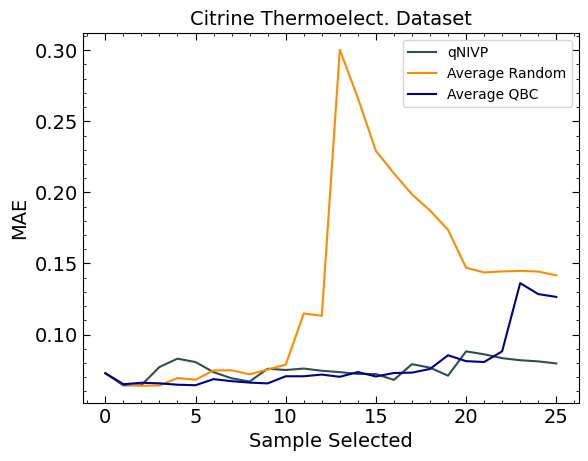

In [233]:
average_mae_commit = np.mean(commit_seeds, axis=0)
average_mae = np.mean(random_mae_seeds, axis=0)
random_trials = [1,2,3,4,5]

# len_trials = range(63)
# plt.errorbar(len_trials,ytest_plt, yerr=pred_std[-1], fmt='o')

plt.plot(pred_mae, color='darkslategray', label='qNIVP')
plt.plot(average_mae, color='darkorange', label='Average Random')
plt.plot(average_mae_commit, color='darkblue', label='Average QBC')
# colors = ['crimson','crimson','crimson','crimson','crimson']
colors = ['orange','orange','orange','orange','orange']
color_ = ['darkblue','darkblue','darkblue','darkblue','darkblue']

# for mae_values, seed, color in zip(random_mae_seeds, random_trials, colors):
#     plt.plot(mae_values, label=f'Random Trial {seed}', color=color,alpha=0.2)
    
# for mae_values, seed, color_ in zip(commit_seeds, random_trials, color_):
#     plt.plot(mae_values, label=f'Committee Trial {seed}', color=color_,alpha=0.2)


# for mae_values, seed, color in zip(random_mae_seeds, random_trials, colors):
#     plt.plot(mae_values, color=color,alpha=0.2)
    
# for mae_values, seed, color_ in zip(commit_seeds, random_trials, color_):
#     plt.plot(mae_values, color=color_,alpha=0.2)

plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.minorticks_on()
plt.title('Citrine Thermoelect. Dataset', size=14)
plt.xlabel('Sample Selected', size=14)
plt.ylabel('MAE', size=14)
plt.legend()
plt.show()

<ErrorbarContainer object of 3 artists>

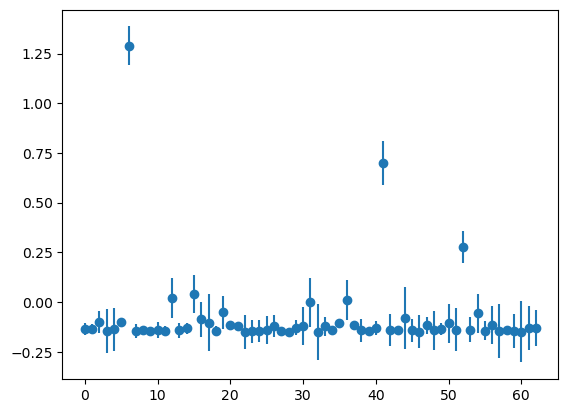

In [215]:
len_trials = range(63)
plt.errorbar(len_trials,ytest_plt, yerr=pred_std[-1], fmt='o')